<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_Overmodulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - The Overmodulation</h1></b>

Dr. Bingsen Wang

11/24/2023
</center>

#Python Code
The Python code illustrates the concept of overmodulation and demonstrates the effect of the third harmonic.  

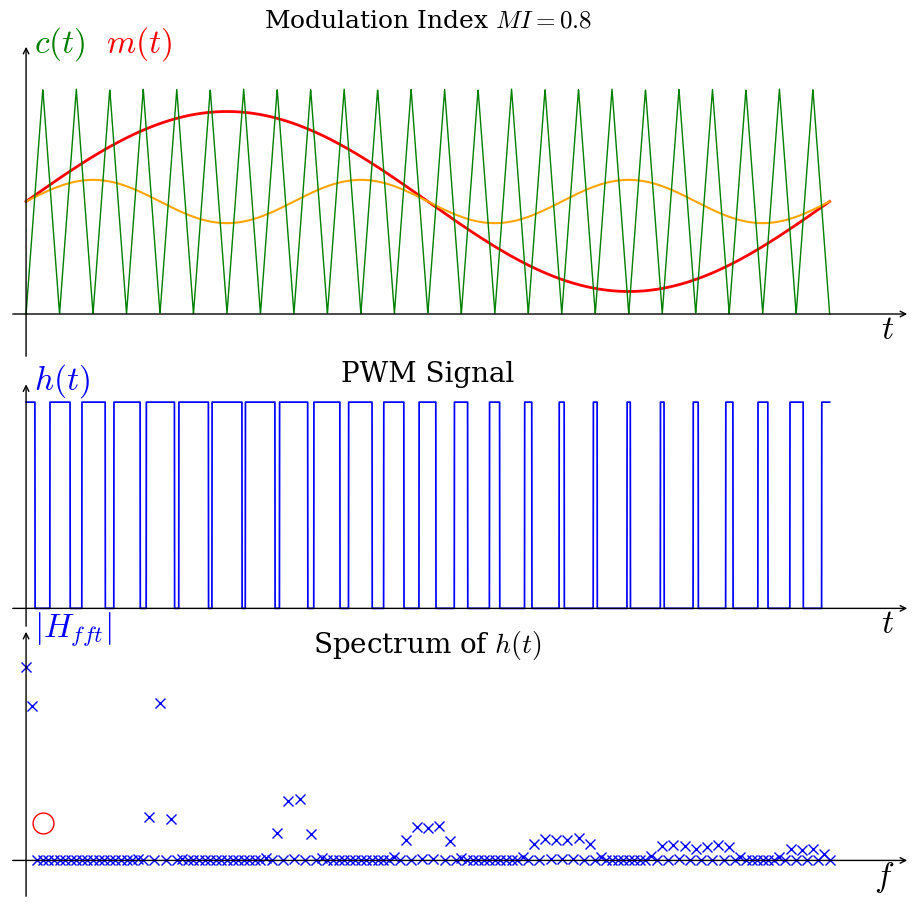

In [84]:
from os import linesep
from numpy import linspace,cos,pi,sin,arccos,heaviside,fft,angle,abs,sqrt,round
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(MI,f,theta,t): #modulation function
  return (MI*sin(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

def yh(A,theta,f,n,t):
  return A*cos(2*pi*n*f*t + theta)

def y_sum(Xfft,f,nn,t): #sum of components, nn: # of harmonics
  yy=0
  for i in range(nn+1): #odd ac components, fundamental & harmonics
    yy = yy + yh(Xfft[0][i], Xfft[1][i], f, i, t)
  return yy

#parameters
Nf = 60 # number of frames
fm = 1 # modulation frequency
fc = 24 # carrier frequency
MI = 2/sqrt(3) # modulation index
MI_v = linspace(0.8,MI,Nf)
MI3rd = 1/6*MI #third harmonic amplitude
MI3rd_v = linspace(0,MI3rd,Nf)
Np = 4096 # number of points for time series

#time series
t=linspace(0,1,Np)
ct = carr(fc,t) #carrier time-domain signal


#spectrum
Nfp = fc*6#number of frequency points
fser = linspace(0,1,Nfp+1)#frequency series

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, .6, 1, .35], [-.02,1.1], [-.2, 1.2]], #recon pwm
            [[0, .3,   1, .275], [-.02,1.1], [-.1, 1.1]], # components
            [[0, 0,   1, .3], [-.02,1.1], [-.1, 0.6]], # spectrum - mag
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[['$c(t)$', '$t$'], ['$h(t)$', '$t$'],['$|H_{fft}|$','$f$']] #yx axes labels
clst=['g','b','b','r'] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k==0:
    lines.append(ax.plot([], [], 'r', lw=2)[0]) #modulation function
    lines.append(ax.plot([], [], 'orange', lw=1.5)[0]) #3rd harmonic
    ax.text(0.1,ym,'$m(t)$',size=24,va='center',color='r') # addtional ylabel
  elif k==1:
    lines.append(ax.plot([], [], clst[k],lw=1.25)[0]) #PWM
  else:
     lines.append(ax.plot([], [], clst[k], ls='', marker='x',markersize=7)[0]) #spectrum
     lines.append(ax.plot([], [], mec=clst[k+1], mfc=(1,1,1,0), ls='', marker='o',markersize=15)[0]) #3rd
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  y_text=ax.text(0.01,ym,ax_lbl[k][0],size=24,va='center',color=clst[k]) #y label
tx_MI=ax_lst[0].text(0.5,ax_frame[0][2][1]+0.1,'',va='center',ha='center',size=18)
ax_lst[1].text(0.5,ax_frame[0][2][1],'PWM Signal',va='top',ha='center',size=20)
ax_lst[2].text(0.5,ax_frame[2][2][1],'Spectrum of $h(t)$',va='top',ha='center',size=20)

ax_lst[0].plot(t,ct,color=clst[0],lw=1) #plot carrier
# animation function. This is called sequentially
def animate(i):
  ii = i%Nf
  if int(i/Nf)==0:
     mt = m(MI_v[ii],fm,0,t)
     if MI_v[i]<=1.0:
      tx_MI.set_text('Modulation Index $MI = '+str(round(MI_v[i], 2))+'$')
     else:
      tx_MI.set_text('Modulation Index $MI= '+str(round(MI_v[i], 2))+"$, in Overmodulation")
  else:
    mt_3rd = 0.5*MI3rd_v[ii]*sin(3*2*pi*fm*t)
    lines[1].set_data(t,mt_3rd+0.5)
    tx_MI.set_text('With 3rd Harmonic Amplitude = $'+str(round(MI3rd_v[ii]/MI,3))+'MI$')
    mt = m(MI,fm,0,t)+mt_3rd #modulation function time series
  ht = h(ct,mt) #pwm signal time series
  hfft = spectrum(ht)
  lines[0].set_data(t,mt)
  lines[2].set_data(t,ht)
  lines[3].set_data(fser,hfft[0][:Nfp+1])
  if int(i/Nf)>0:
    lines[4].set_data([fser[3]],[hfft[0][3]]) #circle the 3rd harmonic
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf*2, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_overmodulation.mp4"
writervideo = animation.FFMpegWriter(fps=2)
anim.save(fn, writer=writervideo,dpi = 120)